In [128]:
!pip install -q scikit-learn nltk streamlit

#IMPORTS

In [129]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
!pip install xgboost
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# DATA LOADING

In [130]:
from google.colab import files
uploaded = files.upload()

Saving problems_data.jsonl to problems_data (2).jsonl


In [131]:
file_name = list(uploaded.keys())[0]
df = pd.read_json(file_name , lines=True)
df.head()

,title,description,input_description,output_description,sample_io,problem_class,problem_score,url
0,Uuu,Unununium (Uuu) was the name of the chemical\n...,The input consists of one line with two intege...,The output consists of $M$ lines where the $i$...,"[{'input': '7 10', 'output': '1 2 2 3 1 3 3 4 ...",hard,9.7,https://open.kattis.com/problems/uuu
1,House Building,A number of eccentrics from central New York h...,"The input consists of $10$ test cases, which a...",Print $K$ lines with\n the positions of the...,"[{'input': '0 2 3 2 50 60 50 30 50 40', 'outpu...",hard,9.7,https://open.kattis.com/problems/husbygge
2,Mario or Luigi,Mario and Luigi are playing a game where they ...,,,"[{'input': '', 'output': ''}]",hard,9.6,https://open.kattis.com/problems/marioorluigi
3,The Wire Ghost,Žofka is bending a copper wire. She starts wit...,The first line contains two integers $L$ and $...,The output consists of a single line consistin...,"[{'input': '4 3 3 C 2 C 1 C', 'output': 'GHOST...",hard,9.6,https://open.kattis.com/problems/thewireghost
4,Barking Up The Wrong Tree,"Your dog Spot is let loose in the park. Well, ...",The first line of input consists of two intege...,Write a single line containing the length need...,"[{'input': '2 0 10 0 10 10', 'output': '14.14'...",hard,9.6,https://open.kattis.com/problems/barktree


#TEXT PREPROCESSING

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4112 entries, 0 to 4111
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               4112 non-null   object 
 1   description         4112 non-null   object 
 2   input_description   4112 non-null   object 
 3   output_description  4112 non-null   object 
 4   sample_io           4112 non-null   object 
 5   problem_class       4112 non-null   object 
 6   problem_score       4112 non-null   float64
 7   url                 4112 non-null   object 
dtypes: float64(1), object(7)
memory usage: 257.1+ KB


In [133]:
df.drop(columns=['url','sample_io','title'],axis=1,inplace=True)


In [134]:
TEXT_COLS = ["description", "input_description", "output_description"]

for col in TEXT_COLS:
    df[col] = df[col].astype(str).str.strip()
    df.loc[df[col] == "", col] = np.nan
df.isna().sum()

,0
description,81
input_description,120
output_description,131
problem_class,0
problem_score,0


In [135]:
df = df.dropna()

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3899 entries, 0 to 4111
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   description         3899 non-null   object 
 1   input_description   3899 non-null   object 
 2   output_description  3899 non-null   object 
 3   problem_class       3899 non-null   object 
 4   problem_score       3899 non-null   float64
dtypes: float64(1), object(4)
memory usage: 182.8+ KB


In [137]:
df["full_text"] = (

    df["description"].fillna("") + " " +
    df["input_description"].fillna("") + " " +
    df["output_description"].fillna("")
)

In [138]:
def clean_text(text):
  text = text.lower()
  text = re.sub(r"\n" , " ", text)
  text = re.sub(r"\t" , " ", text)
  text = re.sub(r"[^a-z0-9\s]" , " " , text)
  text = re.sub(r"\s+" , " ", text)
  return text.strip()

df["clean_text"] = df["full_text"].apply(clean_text)

df["clean_text"].iloc[0][:300]

'unununium uuu was the name of the chemical element with atom number 111 until it changed to r ntgenium rg in 2004 these heavy elements are very unstable and have only been synthesized in a few laboratories you have just been hired by one of these labs to optimize the algorithms used in simulations f'

In [139]:
df = df[["full_text","clean_text", "problem_class", "problem_score"]]


In [140]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3899 entries, 0 to 4111
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   full_text      3899 non-null   object 
 1   clean_text     3899 non-null   object 
 2   problem_class  3899 non-null   object 
 3   problem_score  3899 non-null   float64
dtypes: float64(1), object(3)
memory usage: 152.3+ KB


In [141]:
df.head()

,full_text,clean_text,problem_class,problem_score
0,Unununium (Uuu) was the name of the chemical\n...,unununium uuu was the name of the chemical ele...,hard,9.7
1,A number of eccentrics from central New York h...,a number of eccentrics from central new york h...,hard,9.7
3,Žofka is bending a copper wire. She starts wit...,ofka is bending a copper wire she starts with ...,hard,9.6
4,"Your dog Spot is let loose in the park. Well, ...",your dog spot is let loose in the park well re...,hard,9.6
7,"Three rival gangs of bandits, the Marauders, t...",three rival gangs of bandits the marauders the...,hard,9.5


#DATA VISUALISATION

problem_class
hard      1845
medium    1327
easy       727
Name: count, dtype: int64


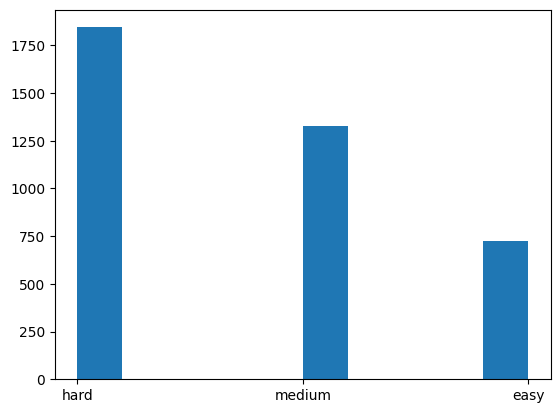

In [142]:
print(df["problem_class"].value_counts())
plt.hist(df['problem_class'])
plt.show()

count    3899.000000
mean        5.113516
std         2.170811
min         1.100000
25%         3.300000
50%         5.200000
75%         6.900000
max         9.700000
Name: problem_score, dtype: float64


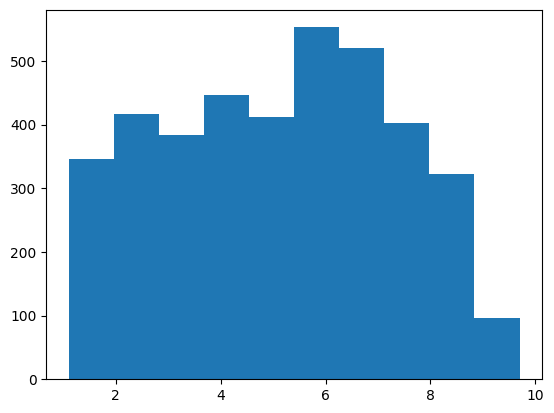

In [143]:
print(df["problem_score"].describe())
plt.hist(df['problem_score'])
plt.show()

In [144]:
df.groupby("problem_class")["problem_score"].mean()


,problem_score
problem_class,
easy,1.977442
hard,7.061734
medium,4.122909


#FEATURE ENGINEERING

In [145]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    lowercase=True,
    max_features=30000,
    ngram_range=(1,2),
    stop_words="english",
    min_df=5,
    max_df = 0.85
)

X_tfidf = tfidf.fit_transform(df["clean_text"])
print("TF-IDF shape:", X_tfidf.shape)


TF-IDF shape: (3899, 11612)


In [146]:
df["text_length"] = df["clean_text"].apply(len)
df["num_words"] = df["clean_text"].apply(lambda x : len(x.split()))


In [147]:
df.groupby("problem_class")["text_length"].mean()
df.groupby("problem_class")["num_words"].mean()

,num_words
problem_class,
easy,226.257221
hard,303.992954
medium,281.287114


In [148]:
def max_numeric_value(text):
    nums = re.findall(r"\d+", text)
    return max(map(int, nums)) if nums else 0

df["max_constraint"] = df["full_text"].apply(max_numeric_value)
df["max_constraint"] = pd.to_numeric(
    df["max_constraint"],
    errors="coerce"
)
df["log_max_constraint"] = np.log1p(df["max_constraint"])


In [149]:
df.groupby("problem_class")["log_max_constraint"].mean()

,log_max_constraint
problem_class,
easy,4.434174
hard,4.265682
medium,4.459020


In [150]:

df["constraint_density"] = df["log_max_constraint"] / (df["num_words"] + 1)
df.groupby("problem_class")["constraint_density"].mean()


,constraint_density
problem_class,
easy,0.022764
hard,0.016242
medium,0.018655


In [151]:
def num_count(text):
    return len(re.findall(r'\d+', text))
df['num_count']=df['clean_text'].apply(num_count)

df.groupby("problem_class")["num_count"].mean()

,num_count
problem_class,
easy,9.067400
hard,12.192412
medium,12.015825


In [152]:
df = df.drop(columns=["max_constraint", "log_max_constraint", "full_text"])


In [153]:
df.head()

,clean_text,problem_class,problem_score,text_length,num_words,constraint_density,num_count
0,unununium uuu was the name of the chemical ele...,hard,9.7,1492,286,0.026493,6
1,a number of eccentrics from central new york h...,hard,9.7,1232,245,0.018761,9
3,ofka is bending a copper wire she starts with ...,hard,9.6,1226,234,0.019639,7
4,your dog spot is let loose in the park well re...,hard,9.6,2017,406,0.009661,6
7,three rival gangs of bandits the marauders the...,hard,9.5,2566,514,0.004656,12


#DATA PREPARATION

In [154]:
extra_features = (
    ["text_length" , "num_words" , "constraint_density", "num_count"]
)

X_extra = df[extra_features].values

X = hstack([X_tfidf , X_extra])

print("Final feature matrix ahpe:" , X.shape)

Final feature matrix ahpe: (3899, 11616)


In [155]:
print("Dataset shape:", df.shape)
print("Feature matrix shape:", X.shape)


Dataset shape: (3899, 7)
Feature matrix shape: (3899, 11616)


In [156]:
scaler = StandardScaler(with_mean=False)
X = scaler.fit_transform(X)

In [157]:
le = LabelEncoder()
df["problem_class_encoded"] = le.fit_transform(df["problem_class"])
y_class = df["problem_class_encoded"]
y_score = df["problem_score"].values

In [158]:
X_train, X_test, y_class_train, y_class_test, y_score_train, y_score_test = train_test_split(
    X, y_class, y_score, test_size=0.2, random_state=42, stratify=y_class
)


#CLASSIFICATION MODEL

In [159]:
model = LogisticRegression(max_iter=2000, class_weight="balanced")

print("="*40)
print("Training LogisticRegression...")

model.fit(X_train, y_class_train)

# Predictions
y_test_pred = model.predict(X_test)

# Metrics
test_acc = accuracy_score(y_class_test, y_test_pred)

precision = precision_score(y_class_test, y_test_pred, average="weighted")
recall = recall_score(y_class_test, y_test_pred, average="weighted")
f1 = f1_score(y_class_test, y_test_pred, average="weighted")

print("LogisticRegression Metrics:")
print(f"Test Accuracy  : {test_acc:.4f}")
print(f"Precision      : {precision:.4f}")
print(f"Recall         : {recall:.4f}")
print(f"F1-score       : {f1:.4f}\n")

cm = confusion_matrix(y_class_test, y_test_pred)
print("Confusion Matrix:")
print(pd.DataFrame(cm, index=le.classes_, columns=le.classes_))


Training LogisticRegression...
LogisticRegression Metrics:
Test Accuracy  : 0.4538
Precision      : 0.4548
Recall         : 0.4538
F1-score       : 0.4504

Confusion Matrix:
        easy  hard  medium
easy      48    49      48
hard      19   214     136
medium    29   145      92


In [160]:
model = LinearSVC(class_weight="balanced", max_iter=5000)

print("="*40)
print("Training LinearSVC...")

model.fit(X_train, y_class_train)

y_test_pred = model.predict(X_test)

test_acc = accuracy_score(y_class_test, y_test_pred)

precision = precision_score(y_class_test, y_test_pred, average="weighted")
recall = recall_score(y_class_test, y_test_pred, average="weighted")
f1 = f1_score(y_class_test, y_test_pred, average="weighted")

print("LinearSVC Metrics:")
print(f"Test Accuracy  : {test_acc:.4f}")
print(f"Precision      : {precision:.4f}")
print(f"Recall         : {recall:.4f}")
print(f"F1-score       : {f1:.4f}\n")

cm = confusion_matrix(y_class_test, y_test_pred)
print("Confusion Matrix:")
print(pd.DataFrame(cm, index=le.classes_, columns=le.classes_))


Training LinearSVC...
LinearSVC Metrics:
Test Accuracy  : 0.4654
Precision      : 0.4613
Recall         : 0.4654
F1-score       : 0.4617

Confusion Matrix:
        easy  hard  medium
easy      53    50      42
hard      29   216     124
medium    33   139      94


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [161]:
model = MultinomialNB()

print("="*40)
print("Training MultinomialNB...")

model.fit(X_train, y_class_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

test_acc = accuracy_score(y_class_test, y_test_pred)

precision = precision_score(y_class_test, y_test_pred, average="weighted")
recall = recall_score(y_class_test, y_test_pred, average="weighted")
f1 = f1_score(y_class_test, y_test_pred, average="weighted")

print("MultinomialNB Metrics:")
print(f"Test Accuracy  : {test_acc:.4f}")
print(f"Precision      : {precision:.4f}")
print(f"Recall         : {recall:.4f}")
print(f"F1-score       : {f1:.4f}\n")

cm = confusion_matrix(y_class_test, y_test_pred)
print("Confusion Matrix:")
print(pd.DataFrame(cm, index=le.classes_, columns=le.classes_))


Training MultinomialNB...
MultinomialNB Metrics:
Test Accuracy  : 0.4410
Precision      : 0.4405
Recall         : 0.4410
F1-score       : 0.4355

Confusion Matrix:
        easy  hard  medium
easy      46    50      49
hard      19   216     134
medium    26   158      82


In [162]:
model = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

print("="*40)
print("Training RandomForest...")

model.fit(X_train, y_class_train)


y_test_pred = model.predict(X_test)


test_acc = accuracy_score(y_class_test, y_test_pred)

precision = precision_score(y_class_test, y_test_pred, average="weighted")
recall = recall_score(y_class_test, y_test_pred, average="weighted")
f1 = f1_score(y_class_test, y_test_pred, average="weighted")

print("RandomForest Metrics:")
print(f"Test Accuracy  : {test_acc:.4f}")
print(f"Precision      : {precision:.4f}")
print(f"Recall         : {recall:.4f}")
print(f"F1-score       : {f1:.4f}\n")

cm = confusion_matrix(y_class_test, y_test_pred)
print("Confusion Matrix:")
print(pd.DataFrame(cm, index=le.classes_, columns=le.classes_))


Training RandomForest...
RandomForest Metrics:
Test Accuracy  : 0.5192
Precision      : 0.5023
Recall         : 0.5192
F1-score       : 0.4721

Confusion Matrix:
        easy  hard  medium
easy      54    72      19
hard      25   305      39
medium    20   200      46


REGRESSION

In [163]:
# Fit model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_score_train)

# Predict on test set
y_pred_reg = lin_reg.predict(X_test)

# Metrics
mae = mean_absolute_error(y_score_test, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_score_test, y_pred_reg))

print("Linear Regression MAE:", mae)
print("Linear Regression RMSE:", rmse)


Linear Regression MAE: 1.8922420728036604
Linear Regression RMSE: 2.32541648723193


In [164]:
# Predict on training set
y_pred_train = lin_reg.predict(X_train)

# Training metrics
train_mae = mean_absolute_error(y_score_train, y_pred_train)
train_rmse = np.sqrt(mean_squared_error(y_score_train, y_pred_train))

print("MAE :", train_mae)
print("RMSE:", train_rmse)


MAE : 0.0016252168357011724
RMSE: 0.04210797942552609


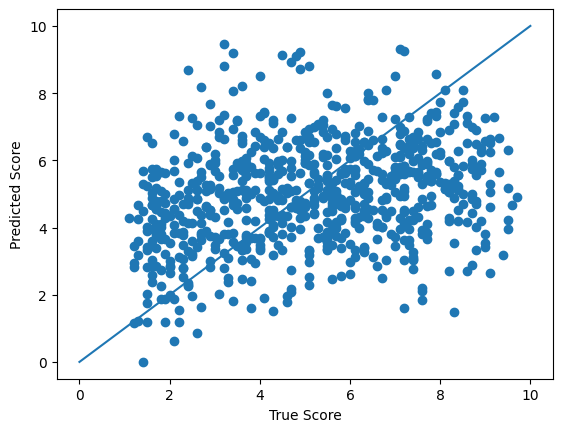

In [165]:
plt.scatter(y_score_test, y_pred_reg)
plt.plot([0,10],[0,10])
plt.xlabel("True Score")
plt.ylabel("Predicted Score")
plt.show()


In [166]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Fit model
lasso_reg = Lasso(alpha=0.01, max_iter=5000)
lasso_reg.fit(X_train, y_score_train)

# Predict on test set
y_pred_lasso = lasso_reg.predict(X_test)

# Metrics
mae = mean_absolute_error(y_score_test, y_pred_lasso)
rmse = np.sqrt(mean_squared_error(y_score_test, y_pred_lasso))

print("Lasso Regression MAE:", mae)
print("Lasso Regression RMSE:", rmse)


Lasso Regression MAE: 1.8707587579809994
Lasso Regression RMSE: 2.274715386996564


In [167]:
# Predict on training set
y_pred_train = lasso_reg.predict(X_train)

# Training metrics
train_mae = mean_absolute_error(y_score_train, y_pred_train)
train_rmse = np.sqrt(mean_squared_error(y_score_train, y_pred_train))

print("MAE :", train_mae)
print("RMSE:", train_rmse)


MAE : 0.39082474805540035
RMSE: 0.482898602678278


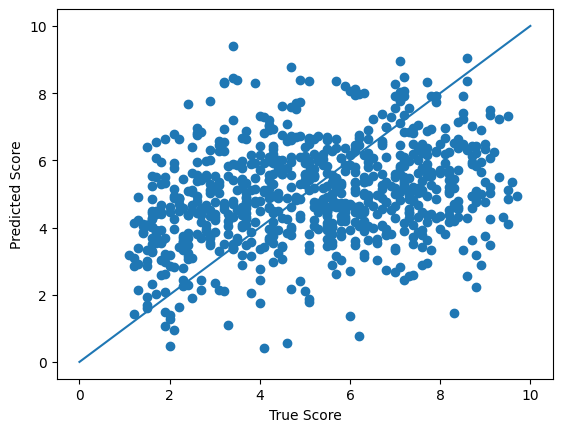

In [168]:
plt.scatter(y_score_test, y_pred_lasso)
plt.plot([0,10],[0,10])
plt.xlabel("True Score")
plt.ylabel("Predicted Score")
plt.show()


In [169]:
# Fit model
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train, y_score_train)

# Predict on test set
y_pred_ridge = ridge_reg.predict(X_test)

# Metrics
mae = mean_absolute_error(y_score_test, y_pred_ridge)
rmse = np.sqrt(mean_squared_error(y_score_test, y_pred_ridge))

print("Ridge Regression MAE:", mae)
print("Ridge Regression RMSE:", rmse)


Ridge Regression MAE: 1.8887724491052247
Ridge Regression RMSE: 2.320852673163077


In [170]:
# Predict on training set
y_pred_train = ridge_reg.predict(X_train)

# Training metrics
train_mae = mean_absolute_error(y_score_train, y_pred_train)
train_rmse = np.sqrt(mean_squared_error(y_score_train, y_pred_train))

print("MAE :", train_mae)
print("RMSE:", train_rmse)


MAE : 0.001973567091782021
RMSE: 0.042149948814396605


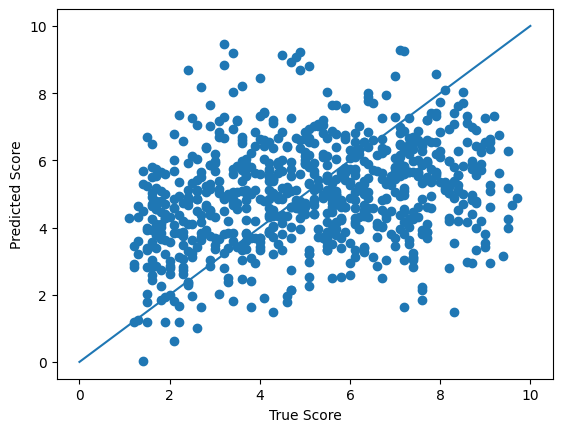

In [171]:
plt.scatter(y_score_test, y_pred_ridge)
plt.plot([0,10],[0,10])
plt.xlabel("True Score")
plt.ylabel("Predicted Score")
plt.show()


In [172]:
# Fit model
xgb_reg = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

xgb_reg.fit(X_train, y_score_train)

# Predict on test set
y_pred_test = xgb_reg.predict(X_test)

# Test metrics
test_mae = mean_absolute_error(y_score_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_score_test, y_pred_test))

print("XGBoost Regression TEST Metrics:")
print("MAE :", test_mae)
print("RMSE:", test_rmse)


XGBoost Regression TEST Metrics:
MAE : 1.7052360761471284
RMSE: 2.029858802308397


In [173]:
# Predict on training set
y_pred_train = xgb_reg.predict(X_train)

# Training metrics
train_mae = mean_absolute_error(y_score_train, y_pred_train)
train_rmse = np.sqrt(mean_squared_error(y_score_train, y_pred_train))

print("XGBoost Regression TRAIN Metrics:")
print("MAE :", train_mae)
print("RMSE:", train_rmse)


XGBoost Regression TRAIN Metrics:
MAE : 0.8544353539762531
RMSE: 1.0372769144850311


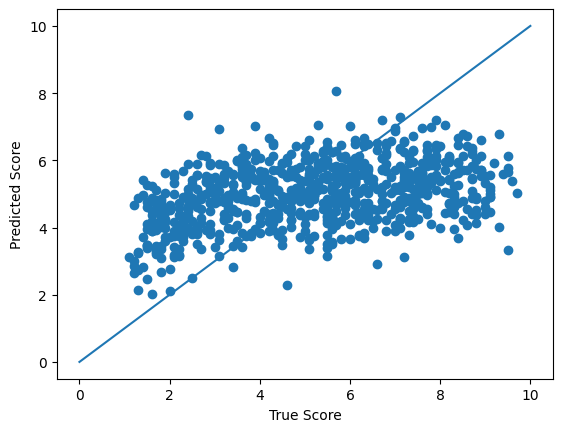

In [174]:
plt.scatter(y_score_test, y_pred_test)
plt.plot([0,10],[0,10])
plt.xlabel("True Score")
plt.ylabel("Predicted Score")
plt.show()


In [175]:

# Fit model
lgbm_reg = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="regression",
    random_state=42,
    n_jobs=-1
)

lgbm_reg.fit(X_train, y_score_train)

# Predict on test set
y_pred_test = lgbm_reg.predict(X_test)

# Test metrics
test_mae = mean_absolute_error(y_score_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_score_test, y_pred_test))

print("LightGBM Regression TEST Metrics:")
print("MAE :", test_mae)
print("RMSE:", test_rmse)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.246916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 71062
[LightGBM] [Info] Number of data points in the train set: 3119, number of used features: 2449
[LightGBM] [Info] Start training from score 5.107118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [176]:
# Predict on training set
y_pred_train = lgbm_reg.predict(X_train)

# Training metrics
train_mae = mean_absolute_error(y_score_train, y_pred_train)
train_rmse = np.sqrt(mean_squared_error(y_score_train, y_pred_train))

print("MAE :", train_mae)
print("RMSE:", train_rmse)


MAE : 1.0809109893869713
RMSE: 1.3131886140239701


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


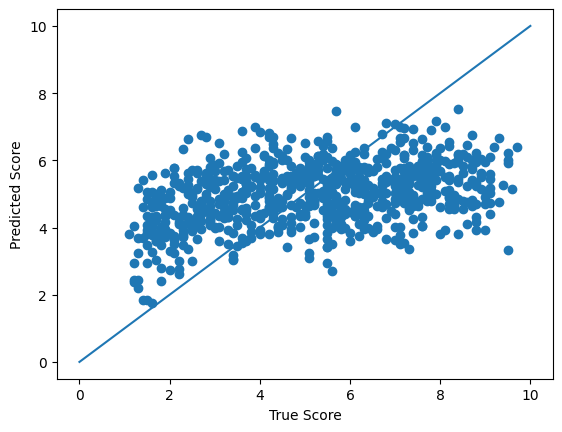

In [177]:
plt.scatter(y_score_test, y_pred_test)
plt.plot([0,10],[0,10])
plt.xlabel("True Score")
plt.ylabel("Predicted Score")
plt.show()


#SAVING THE MODEL

In [179]:
import joblib
# 1. Select your best model (e.g., the LightGBM Classifier)
best_model_clf = model  # Or your SVM/LogisticRegression variable
best_model_reg = xgb_reg  # Or your SVM/LogisticRegression variable

# 2. Save the model and the scaler
joblib.dump(best_model_clf, 'clf_model.pkl')
joblib.dump(best_model_reg, 'reg_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le, 'label_encoder.pkl')
joblib.dump(tfidf, 'tfidf.pkl')

# 3. Download these files to your local computer
from google.colab import files
files.download('clf_model.pkl')
files.download('reg_model.pkl')
files.download('scaler.pkl')
files.download('label_encoder.pkl')
files.download('tfidf.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>